In [267]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from numpy.linalg import inv

from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import MinMaxScaler


In [260]:
# ====================== DATA PREPROCESSING ======================
# Load data

df = pd.read_csv(r"c:\Users\c0a02nu\Downloads\HR_Process_Dataset.csv")

X = df.drop(columns=['EmployeeID', 'MonthlyIncome'], axis=1) 

y = df['MonthlyIncome'] 

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Preprocessing

numerical_cols = ['HourlnWeek', 'SalaryHikelastYear', 'Age', 'HomeToWork'] 

X_train_cat = X_train.drop(columns=numerical_cols) 

X_test_cat = X_test.drop(columns=numerical_cols) 

scaler = MinMaxScaler() 

X_train_num = scaler.fit_transform(X_train[numerical_cols]) 

X_test_num = scaler.transform(X_test[numerical_cols]) 

X_train_final = np.hstack([X_train_num, X_train_cat])

X_test_final = np.hstack([X_test_num, X_test_cat])

# Scale target

y_scaler = MinMaxScaler()

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Add intercept

X_train_final = np.hstack([np.ones((X_train_final.shape[0], 1)), X_train_final])

X_test_final = np.hstack([np.ones((X_test_final.shape[0], 1)), X_test_final])


In [261]:

# ====================== BAYESIAN LINEAR REGRESSION ======================
class BayesianLinearRegression:
   def __init__(self, alpha=1.0, beta=1.0):
       """
       alpha: prior precision (inverse variance) of weights
       beta: noise precision (inverse variance)
       """
       self.alpha = alpha
       self.beta = beta
       self.m = None  # Posterior mean
       self.S = None  # Posterior covariance
   def fit(self, X, y):
       """Compute posterior distribution over weights"""
       D = X.shape[1]
       S_prior_inv = self.alpha * np.eye(D)
       S_inv = S_prior_inv + self.beta * X.T @ X
       self.S = inv(S_inv)
       self.m = self.beta * self.S @ X.T @ y
   def predict(self, X, return_std=False):
       """Make predictions with optional uncertainty"""
       y_pred = X @ self.m
       if return_std:
           y_var = 1/self.beta + np.sum(X @ self.S * X, axis=1)
           return y_pred, np.sqrt(y_var)
       return y_pred
   def sample_weights(self, n_samples=1):
       """Sample weights from posterior"""
       return np.random.multivariate_normal(self.m, self.S, n_samples)
   def sample_predictions(self, X, n_samples=1):
       """Sample predictions including observation noise"""
       w_samples = self.sample_weights(n_samples)
       noise = np.random.normal(0, 1/np.sqrt(self.beta), (X.shape[0], n_samples))
       return X @ w_samples.T + noise
   def log_likelihood(self, X, y):
       """Calculate log-likelihood of data"""
       y_pred = X @ self.m
       N = len(y)
       return -0.5 * N * np.log(2*np.pi) + 0.5*N*np.log(self.beta) \
              - 0.5*self.beta*np.sum((y - y_pred)**2)
   def marginal_likelihood(self, X, y):
       """Calculate log marginal likelihood (model evidence)"""
       N, D = X.shape
       term1 = 0.5*D*np.log(self.alpha) + 0.5*N*np.log(self.beta)
       term2 = -0.5*(self.beta*np.sum((y - X@self.m)**2) + self.alpha*np.sum(self.m**2))
       term3 = -0.5*np.log(np.linalg.det(self.alpha*np.eye(D) @ self.S))
       term4 = -0.5*N*np.log(2*np.pi)
       return term1 + term2 + term3 + term4
   def bic(self, X, y):
       """Bayesian Information Criterion"""
       return -2*self.log_likelihood(X, y) + X.shape[1]*np.log(len(y))
   def aic(self, X, y):
       """Akaike Information Criterion"""
       return -2*self.log_likelihood(X, y) + 2*X.shape[1]

In [262]:
# ====================== MODEL TRAINING & EVALUATION ======================
def bayesian_cv(X, y, alpha_values, beta_values, n_folds=5):
   """Cross-validation for hyperparameter tuning"""
   kf = KFold(n_folds)
   results = []
   for alpha in alpha_values:
       for beta in beta_values:
           metrics = {'alpha': alpha, 'beta': beta,
                     'avg_log_lik': 0, 'avg_bic': 0, 'avg_aic': 0}
           for train_idx, val_idx in kf.split(X):
               X_train, X_val = X[train_idx], X[val_idx]
               y_train, y_val = y[train_idx], y[val_idx]
               model = BayesianLinearRegression(alpha, beta)
               model.fit(X_train, y_train)
               metrics['avg_log_lik'] += model.marginal_likelihood(X_val, y_val)
               metrics['avg_bic'] += model.bic(X_val, y_val)
               metrics['avg_aic'] += model.aic(X_val, y_val)
           # Average across folds
           for k in ['avg_log_lik', 'avg_bic', 'avg_aic']:
               metrics[k] /= n_folds
           results.append(metrics)
   return pd.DataFrame(results)
# Hyperparameter grid
alpha_values = [0.1, 1.0, 10.0]
beta_values = [1.0, 10.0, 100.0]
# Run cross-validation
cv_results = bayesian_cv(X_train_final, y_train_scaled, alpha_values, beta_values)
# Select best model
best_idx = cv_results['avg_log_lik'].idxmax()
best_alpha = cv_results.loc[best_idx, 'alpha']
best_beta = cv_results.loc[best_idx, 'beta']
print(f"Best hyperparameters: alpha={best_alpha}, beta={best_beta}")
# Train final model
final_model = BayesianLinearRegression(alpha=best_alpha, beta=best_beta)
final_model.fit(X_train_final, y_train_scaled)

Best hyperparameters: alpha=0.1, beta=100.0


In [263]:
# ====================== VISUALIZATION & EVALUATION ======================

# Predictions with uncertainty
y_pred, y_std = final_model.predict(X_test_final, return_std=True)

# Reverse the scaling of y_test_scaled if you want to plot the actual income values
y_test_actual = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))  # Reverse scaling for y_test_scaled
y_pred_actual = y_scaler.inverse_transform(y_pred.reshape(-1, 1))  # Reverse scaling for predictions
print(y_test_actual)
print(y_pred_actual)



[[21396.]
 [18368.]
 [34566.]
 ...
 [34606.]
 [17478.]
 [26400.]]
[[21064.79912739]
 [18446.32449643]
 [34822.8033683 ]
 ...
 [34631.53509889]
 [18258.09648617]
 [25109.68876766]]


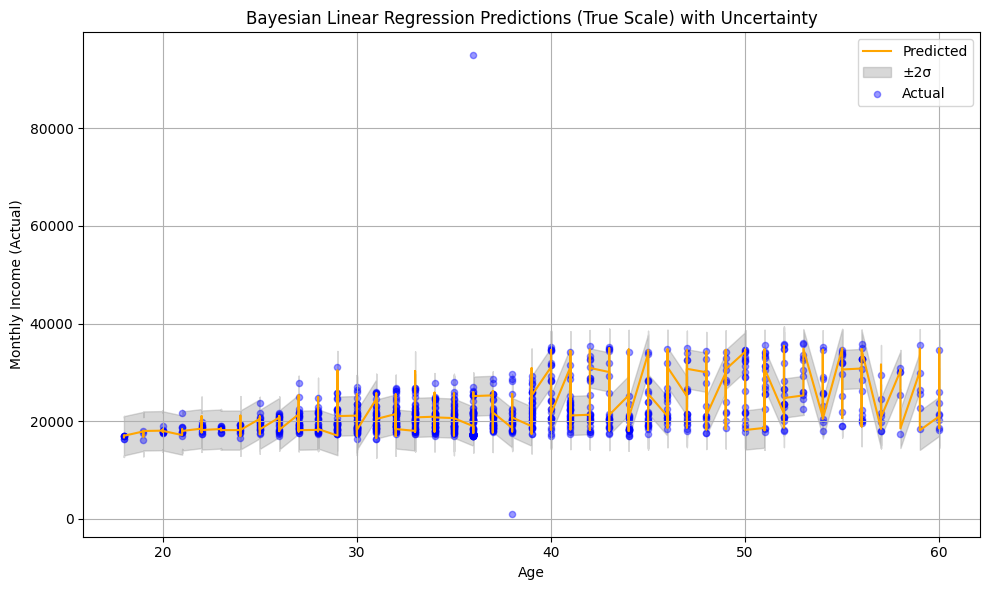

In [264]:

# Choose the x-axis feature for plotting
x_axis_feature = 'Age'  # <- Change this to any numerical feature you want
x_values = X_test[x_axis_feature].values

# Inverse transform predictions and actuals back to original Monthly Income scale
y_pred_actual = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Rescale uncertainty to original scale
y_std_actual = y_std * (y_scaler.data_max_ - y_scaler.data_min_)

# Sort for smooth line plot (optional but looks cleaner)
sort_idx = np.argsort(x_values)
x_sorted = x_values[sort_idx]
y_pred_sorted = y_pred_actual[sort_idx]
y_std_sorted = y_std_actual[sort_idx]
y_test_sorted = y_test_actual[sort_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_sorted, y_pred_sorted, color='orange', label='Predicted')
plt.fill_between(x_sorted,
                 y_pred_sorted - 2 * y_std_sorted,
                 y_pred_sorted + 2 * y_std_sorted,
                 alpha=0.3, color='gray', label='±2σ')
plt.scatter(x_sorted, y_test_sorted, alpha=0.4, color='blue', label='Actual', s=20)
plt.xlabel(x_axis_feature)
plt.ylabel('Monthly Income (Actual)')
plt.title('Bayesian Linear Regression Predictions (True Scale) with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [265]:
# Model evaluation

test_log_lik = final_model.log_likelihood(X_test_final, y_test_scaled)

test_bic = final_model.bic(X_test_final, y_test_scaled)

test_aic = final_model.aic(X_test_final, y_test_scaled)

print(f"\nTest Set Evaluation:")

print(f"Log Likelihood: {test_log_lik:.2f}")

print(f"BIC: {test_bic:.2f}")

print(f"AIC: {test_aic:.2f}")
print(f"RMSE: {np.sqrt(np.mean((y_pred - y_test_scaled)**2)):.4f}")


Test Set Evaluation:
Log Likelihood: 396.43
BIC: -570.69
AIC: -728.87
RMSE: 0.1415
